# Duplicates Detection Method

In [34]:
### IMPORT PACKAGES

import sys
import pandas as pd
import numpy as np
import json
import kshingle as ks
import random 
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import math
import tqdm
import matplotlib.pyplot as plt
import hashlib

np.set_printoptions(threshold=sys.maxsize)

### 1.1 Load Data

In [35]:
# Open JSON file
with open('TVs-all-merged.json') as f:
  data = json.load(f)

print(type(data))

print(len(data.keys()))

<class 'dict'>
1262


### 2.1 Define all functions

In [36]:
# Function for number of product descriptions
def total_products(data):
    total_products = 0
    for key in data.keys():
        total_products += len(data[key]) 
    print(total_products)

# Split descriptions to make separate dictionary
def get_product_dicts(data):
    product_dicts = {}
    i=0
    for key in data.keys():
        for product in data[key]:
            product_dicts[i] = product
            i += 1
    return product_dicts

# Get modelIDs to check duplicates
def get_model_IDs(product_dicts):
    modelIDs = []
    for p in product_dicts.keys():
        modelIDs.append(product_dicts[p]['modelID'])
    return modelIDs

# Remove type of description and 
def get_products(product_dicts):
    products = {}
    i = 0
    for key in product_dicts.keys():
        products[i] = []
        for description in product_dicts[key]:
            if description == 'title' :
                products[i].append(product_dicts[key][description])
            elif description == 'featuresMap':
                for feature in product_dicts[key][description].keys():
                    products[i].append(product_dicts[key][description][feature])
        i += 1
    return products

# Get all titles for bootstrapping
def get_titles(products):
    titles = []
    for product in products:
        titles.append(products[product]["title"])
    return titles

# Bootstrap function
def create_bootstraps(b, products):    
    train_set = []
    test_set = []
    for i in range(b):
        boot = random.choices(range(len(products)), k=len(products))
        boot_noDuplicates = list(set(boot))
        complete = list(range(len(boot)))
        train_set.append(sorted(boot))
        test = list(set(complete) - set(train_set[i]))
        test_set.append(test)
    return train_set, test_set, boot_noDuplicates


# Extract model words title from key-value pairs
def extract_mw(products):
    model_words = []
    for key in products.keys():
        title_mw = ["".join(x[0]) for x in re.findall(r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)', products[key][-1])]
        for subitem in title_mw:
            if subitem is not None and subitem not in model_words:
                model_words.append(subitem)
        for item in products[key][:-1]:
            keyvalue_mw = re.findall(r'(ˆ\d+(\.\d+)?[a-zA-Z]+$|ˆ\d+(\.\d+)?$)', item)
            if keyvalue_mw is not None and keyvalue_mw not in model_words:
                model_words.append(keyvalue_mw)
    for mw in model_words:
        if not isinstance(mw, str):
            model_words.remove(mw)
    return model_words

# Count occurrence of a string in whole dictionary
def occurrence_counter(products, string):
    count = 0
    for key in products.keys():
        for item in products[key]:
            count += item.count(string)
    print(count)

# Data cleaning
def clean_data(products_raw):
    products = {}
    for key in products_raw.keys():
        products[key] = []
        for item in products_raw[key]:
            item = item.replace('"', 'inch').replace('-inch', 'inch').replace('inches', 'inch').replace(' inch', 'inch').replace('inch', 'inch').replace('-Inch', 'inch')
            item = item.replace('Hertz', 'hz').replace('hertz', 'hz').replace('Hz', 'hz').replace('HZ', 'hz').replace('-hz', 'hz').replace('hz', 'hz')
            products[key].append(item)
    return products

# Create binary matrix
def get_bin_matrix(products, model_words):    
    binary_matrix = None
    i = 0
    for product in products:
        bin_list = []
        for mw in model_words:
            if any(mw in item for item in products[product]):
                bin_list.append(1)
            else:
                bin_list.append(0) 
        bin_vec = np.array(bin_list)
        if i == 0:
            binary_matrix = bin_vec # Initialize matrix
        else:
            binary_matrix = np.c_[binary_matrix, bin_vec] # Append column for product i
        i += 1
    return binary_matrix

# Generate random prime number
def primeNumbers(a,b):
    list_of_primes = []
    for n in range(a,b):
        isPrimeNumber = True
        for number in range(2,n):
            if n % number == 0:
                isPrimeNumber == False
        if isPrimeNumber == True:
            list_of_primes.append(n)
    return list_of_primes

# Gernerate hash functions
def hash_funcs(model_words, binary_matrix):
    n = round(len(model_words)/2) # Number of hash functions equal to half of the model words 
    primes = primeNumbers(n, n + 200)
    p = random.choice(primes)
    a = []
    b = []
    for i in range(0,n):
        a.append(random.randint(0, len(model_words)))
        b.append(random.randint(1,len(model_words)))
    hash_func_values = [[0 for i in range(len(binary_matrix))] for j in range(n)]
    for j in range(0, len(a)):
        for i in range(0, len(binary_matrix)):
            hash_func_values[j][i] = (a[j]+b[j]*i)%p
    return hash_func_values

# Create Signature Matrix
def MinHash(binary_matrix, model_words, products, hash_func_values):
    columns = list(range(len(binary_matrix)))
    binary_matrix_pd = pd.DataFrame(binary_matrix, columns)
    transposed_binary_matrix = binary_matrix_pd.transpose() # Slide 40 of LSH lecture, sort matrix to compute hashed values once for each row
    n = round(len(model_words)/2)
    sig = [float('inf')]*n 
    signatures = [sig]*(len(transposed_binary_matrix))
    signatures = np.array(signatures)

    for i in range(len(transposed_binary_matrix)): # rows, represent product descriptions
        for j in range(len(binary_matrix_pd)): # columns, represent model words
            if transposed_binary_matrix.iloc[i,j] == 1: # Check the permutations
                for other in range(len(hash_func_values)): # Check for other hashed values
                    if hash_func_values[other][j] < signatures[i,other]: # value per hash
                        signatures[i,other] = hash_func_values[other][j]

    signatures = np.transpose(signatures)
    signatures = signatures.astype(int)
    #signatures = pd.DataFrame(signatures, index=products.keys())
    #signatures.columns = np.arange(1, n+1)
    
    return signatures

# Create LSH function
def LSH(signature_matrix, binary_matrix, products, model_words, r):

    blength = r  # r in LSH method
    n = round(len(model_words)/2)
    total_bands = int(n/blength) # b in LSH
    t = round((1/total_bands)**(1/blength), 2)

    candidate_set = get_all_candidates(signature_matrix, binary_matrix, total_bands, blength, t)

    return candidate_set

# Get number of comparisons
def number_of_comparisons(candidate_matrix):
    number_of_comparisons = np.sum(candidate_matrix)
    
    return number_of_comparisons 

# Function for total number of comparisons
def total_possible_comparisons(candidate_matrix):
    ones_lower = np.tril(np.ones((len(candidate_matrix),len(candidate_matrix))))
    np.fill_diagonal(ones_lower, 0)
    total_possible = np.sum(ones_lower)
    
    return total_possible

# Function for Pair Quality
def pairquality(duplicates_found, num_of_comp):
    pq = duplicates_found / num_of_comp

    return pq

# Function for Pair Completeness
def paircompleteness(duplicates_found, total_real_duplicates):
    pc = duplicates_found / total_real_duplicates

    return pc

# Function for F1*
def F1star(pq, pc):
    F1star_score = (pq + pc)/2

    return F1star_score

# Function for F1
def F1(TP, FP, TN, FN):
    precision = (TP+1) / (TP+1 + FP)
    recall = (TP+1) / (TP+1 + FN)
    F1 = (2*precision*recall)/(precision+recall)

    return F1

# Function for fraction of comparisons
def frac_of_comparisons(num_of_comp, total_possible):
    frac = num_of_comp/total_possible

    return frac
    
# Function to find all real duplicates and also returns total 
def get_realduplicates(modelIDs):    
    real_duplicates = set()
    for i in range(len(modelIDs)):
        for j in range(len(modelIDs)):
            if modelIDs[i] == modelIDs[j] and i != j:
                real_duplicates.add(tuple(sorted( (i,j) )))
                
    total = len(real_duplicates)

    return real_duplicates, total

# Candidate evaluation
def evaluate_candidates(candidates, real_duplicates, products):
    detected_duplicate_matrix = np.zeros((len(products),len(products)))
    real_duplicate_matrix = np.zeros((len(products),len(products)))

    FN = 0
    FP = 0
    TN = 0
    TP = 0

    for cand in candidates:
        title1 = products[cand[0]][-1]
        title2 = products[cand[1]][-1]
        # Remove store from title
        title1 = title1.replace('- Best Buy', '').replace('Newegg.com -', '').replace('- Newegg.com', '').replace('- TheNerds.net', '')
        title2 = title2.replace('- Best Buy', '').replace('Newegg.com -', '').replace('- Newegg.com', '').replace('- TheNerds.net', '')
        comp = [title1,title2]
        vectorizer = CountVectorizer().fit_transform(comp)
        vectors = vectorizer.toarray()
        if detected_duplicate_matrix[cand[0], cand[1]] == 0:
            detected_duplicate_matrix[cand[0], cand[1]] = (1 if cossim(vectors[0],vectors[1]) > 0.5 else 0)

    idx_r = np.r_[list(real_duplicates)].T
    real_duplicate_matrix[idx_r[0], idx_r[1]] = 1

    for i in range(len(detected_duplicate_matrix)):
        for j in range(len(detected_duplicate_matrix)):
            if detected_duplicate_matrix[i,j] == 0 and real_duplicate_matrix[i,j] == 0:
                TN += 1
            elif detected_duplicate_matrix[i,j] == 1 and real_duplicate_matrix[i,j] == 0:
                FP += 1
            elif detected_duplicate_matrix[i,j] == 0 and real_duplicate_matrix[i,j] == 1:
                FN += 1
            elif detected_duplicate_matrix[i,j] == 1 and real_duplicate_matrix[i,j] == 1:
                TP += 1

    return TP, TN, FP, FN , real_duplicate_matrix, detected_duplicate_matrix

# Compute Cosine similarity
def cossim(u,v):
    norm = np.linalg.norm(u)*np.linalg.norm(v)
    cosine = u@v/norm
    return cosine 

# Compute Jaccard similarity
def jaccard(u,v):
    intersection = np.logical_and(u, v)
    union = np.logical_or(u, v)
    jacsim = np.sum(intersection) / float(np.sum(union))
    return jacsim

# Split the signature matrix into the number of bands
def get_sig_bands(signature_matrix, total_bands, blength):
    bands = {}
    for i in range(total_bands):
        bands[i] = []

    for signature in signature_matrix.T:
        for i in range(total_bands):
            index = i*blength
            bands[i].append(' '.join(str(x) for x in signature[index:index+blength]))

    return bands

# Hash the values of a band to a bucket
def get_band_buckets(band, hash_f): 
    buckets = {}
    for prodID in range(len(band)):
        val = hash_f.get_hash_value(band[prodID])
        if val not in buckets:
            buckets[val] = [prodID]
        else:
            buckets[val].append(prodID)
    return buckets

# Get the candidates of a band
def get_candidates(buckets):
    candidates_raw = set()
    for bucket, can_lst in buckets.items():
        if len(can_lst) > 1:
            for i in range(len(can_lst)-1):
                for j in range(i+1, len(can_lst)):
                    pair = tuple(sorted((can_lst[i], can_lst[j])))
                    candidates_raw.add(pair)
    return candidates_raw

#Verify the found candidate pairs
def verify_candidates(candidates_raw, t, signature_matrix):
    candidates = set()
    for pair in candidates_raw:
        first = pair[0]
        second = pair[1]
        first_prod = list(signature_matrix[:, first])
        second_prod = list(signature_matrix[:, second])
        jacsim = jaccard(first_prod, second_prod)#len(first_prod.intersection(second_prod)) /len(first_prod.union(second_prod))
        #cos = cossim(np.array(list(first_prod)), np.array(list(second_prod)))
        if jacsim >= t:
            candidates.add(tuple(sorted((first, second))))
        
    return candidates

# Get the candidates occurring in all the bands
def get_all_candidates(signature_matrix, binary_matrix, total_bands, blength, t):
    candidate_set = set()
    bands = get_sig_bands(signature_matrix, total_bands, blength)
    
    for band, items in bands.items():
        i = random.randint(0,10000000000)
        hash_code = str(i).zfill(10)[-10:]
        buckets = get_band_buckets(items, hash_f=hashFamily(hash_code))
        candidates_raw = get_candidates(buckets)
        candidates = verify_candidates(candidates_raw, t, signature_matrix)
        for candidate in candidates:
            candidate_set.add(candidate)
    return candidate_set

# Class for the hashing of bands into buckets 
class hashFamily:
    def __init__(self, i):
        self.resultSize = 8 # how many bytes we want back
        self.maxLen = 20 # how long can our salt be (in decimal)
        self.salt = str(i).zfill(self.maxLen)[-self.maxLen:]

    def get_hash_value(self, el_to_hash):
        return int(hashlib.sha1(str(el_to_hash).encode('utf-8') + self.salt.encode('utf-8')).hexdigest()[-self.resultSize:], 16)


### 2.2 Duplicate Detection Model

In [37]:
def full_detection_model(products, product_dicts, rows):    
    r = rows
    model_words = extract_mw(products)

    binary_matrix = get_bin_matrix(products, model_words)
    
    hash_func_values = hash_funcs(model_words, binary_matrix)

    signature_matrix = MinHash(binary_matrix, model_words, products, hash_func_values)

    candidate_set = LSH(signature_matrix, binary_matrix, products, model_words, r)

    modelIDs = get_model_IDs(product_dicts)
    real_duplicates_set, total_realdup = get_realduplicates(modelIDs)

    TP, TN, FP, FN, real_duplicate_matrix, detected_duplicate_matrix = evaluate_candidates(candidate_set, real_duplicates_set, products)

    num_of_comp = number_of_comparisons(detected_duplicate_matrix)
    total_possible_comp = total_possible_comparisons(detected_duplicate_matrix)
    fraction = frac_of_comparisons(num_of_comp, total_possible_comp)
    pq = pairquality(TP, num_of_comp)
    pc = paircompleteness(TP, total_realdup)

    F1_score = F1(TP, FP, TN, FN)
    F1star_score = F1star(pq, pc)

    return fraction, F1_score, F1star_score





### For each bootstrap

In [38]:
product_dicts = get_product_dicts(data)

products_raw = get_products(product_dicts)

products = clean_data(products_raw)
num_of_bootstraps = 5
train_set, test_set, boot_noDuplicates = create_bootstraps(num_of_bootstraps, products)
#product_dicts_boot = dict(enumerate(product_dicts.values()))

outcomes3 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    product_dicts_boot = {}
    i=0
    for index in test_set[j]:
        products_boot.update({index : products[index]})
        product_dicts_boot[i] = product_dicts[index]
        i+=1
    products_boot = dict(enumerate(products_boot.values()))
    outcome = full_detection_model(products_boot, product_dicts_boot, rows=3)
    outcomes3.append(outcome)

frac_avg3 = (outcomes3[0][0]+outcomes3[1][0]+outcomes3[2][0]+outcomes3[3][0]+outcomes3[4][0])/5
F1_avg3 = (outcomes3[0][1]+outcomes3[1][1]+outcomes3[2][1]+outcomes3[3][1]+outcomes3[4][1])/5
F1star_avg3 = (outcomes3[0][2]+outcomes3[1][2]+outcomes3[2][2]+outcomes3[3][2]+outcomes3[4][2])/5

outcomes6 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    product_dicts_boot = {}
    i=0
    for index in test_set[j]:
        products_boot.update({index : products[index]})
        product_dicts_boot[i] = product_dicts[index]
        i+=1
    products_boot = dict(enumerate(products_boot.values()))
    outcome = full_detection_model(products_boot, product_dicts_boot, rows=6)
    outcomes6.append(outcome)

frac_avg6 = (outcomes6[0][0]+outcomes6[1][0]+outcomes6[2][0]+outcomes6[3][0]+outcomes6[4][0])/5
F1_avg6 = (outcomes6[0][1]+outcomes6[1][1]+outcomes6[2][1]+outcomes6[3][1]+outcomes6[4][1])/5
F1star_avg6 = (outcomes6[0][2]+outcomes6[1][2]+outcomes6[2][2]+outcomes6[3][2]+outcomes6[4][2])/5


outcomes9 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    product_dicts_boot = {}
    i=0
    for index in test_set[j]:
        products_boot.update({index : products[index]})
        product_dicts_boot[i] = product_dicts[index]
        i+=1
    products_boot = dict(enumerate(products_boot.values()))
    outcome = full_detection_model(products_boot, product_dicts_boot, rows=9)
    outcomes9.append(outcome)

frac_avg9 = (outcomes9[0][0]+outcomes9[1][0]+outcomes9[2][0]+outcomes9[3][0]+outcomes9[4][0])/5
F1_avg9 = (outcomes9[0][1]+outcomes9[1][1]+outcomes9[2][1]+outcomes9[3][1]+outcomes9[4][1])/5
F1star_avg9 = (outcomes9[0][2]+outcomes9[1][2]+outcomes9[2][2]+outcomes9[3][2]+outcomes9[4][2])/5

outcomes18 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    product_dicts_boot = {}
    i=0
    for index in test_set[j]:
        products_boot.update({index : products[index]})
        product_dicts_boot[i] = product_dicts[index]
        i+=1
    products_boot = dict(enumerate(products_boot.values()))
    outcome = full_detection_model(products_boot, product_dicts_boot, rows=18)
    outcomes18.append(outcome)

frac_avg18 = (outcomes18[0][0]+outcomes18[1][0]+outcomes18[2][0]+outcomes18[3][0]+outcomes18[4][0])/5
F1_avg18 = (outcomes18[0][1]+outcomes18[1][1]+outcomes18[2][1]+outcomes18[3][1]+outcomes18[4][1])/5
F1star_avg18 = (outcomes18[0][2]+outcomes18[1][2]+outcomes18[2][2]+outcomes18[3][2]+outcomes18[4][2])/5





In [39]:
f1 = [F1_avg3,F1_avg6,F1_avg9,F1_avg18]
f1star = [F1star_avg3, F1star_avg6, F1star_avg9, F1star_avg18]
fracs = [frac_avg3, frac_avg6, frac_avg9, frac_avg18]


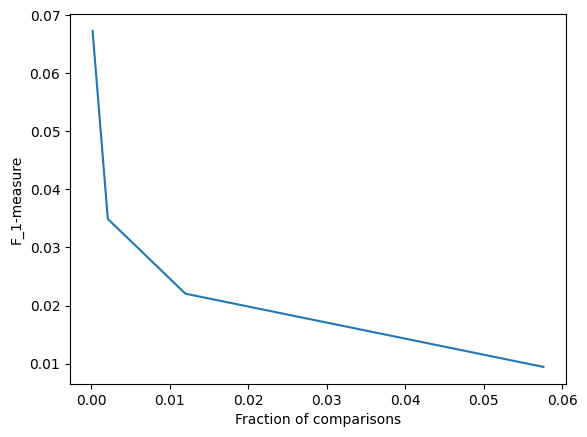

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(fracs, f1)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1-measure')
# plt.xlim(0,0.6)
# plt.ylim(0,0.4)
plt.show()
plt.savefig('figuref1.png')


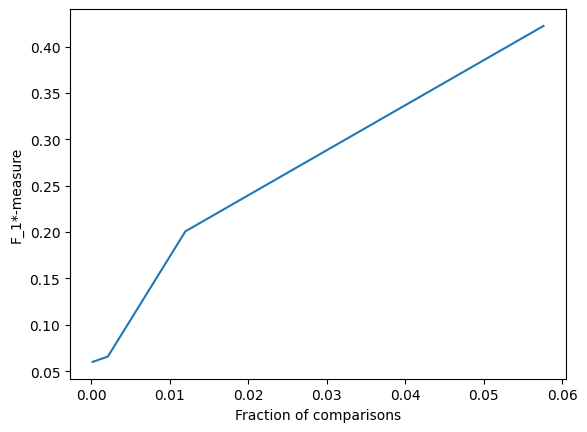

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(fracs, f1star)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1*-measure')
# plt.xlim(0,0.6)
# plt.ylim(0,0.4)
plt.show()
plt.savefig('figuref1star.png')

In [46]:
f1

[0.009426254017311673,
 0.022040402932386745,
 0.03491631681587747,
 0.06729880693756682]

In [47]:
f1star

[0.4222271348204384,
 0.20082093516821842,
 0.06578415560495925,
 0.06003310881063621]

In [48]:
fracs

[0.05759384290865858,
 0.011993379255610385,
 0.0021125202830398772,
 0.0001691961774016977]

In [49]:
words_t1 = set(products[9][-1].split())
words_t2 = set(products[10][-1].split())

cos = float(len(words_t1.intersection(words_t2))) / len(words_t1.union(words_t2))
jac

0.35294117647058826